In [1]:
%matplotlib inline
import glob
import os
import lz4
import matplotlib
import cv2
import numpy as np
from matplotlib import pyplot as plt

plt.style.use("ggplot")

In [2]:
import ctypes
from ctypes import cdll
lz4 = cdll.LoadLibrary("liblz4.so")

In [3]:
def imread_from_lz4(fname):
    with open(fname, "rb") as f:
        contents = f.read()
    bufsize = 6221000
    dst = ctypes.create_string_buffer(bufsize)
    lz4.LZ4_decompress_safe(contents, dst, len(contents), bufsize)
    return cv2.imdecode(np.frombuffer(dst.raw), cv2.IMREAD_ANYCOLOR)

In [4]:
rt_path = "ssd/liyan_scene_scan/"
file_list = [os.path.splitext(os.path.basename(f))[0][:-4] for f in glob.glob(rt_path + "*.bmp.lz4")]

In [5]:
counters = sorted([int(n.split("-")[2]) for n in file_list])

dropped = []
for i in range(len(counters) - 1):
    if counters[i + 1] - counters[i] > 1:
        dropped.append((i, counters[i + 1] - counters[i]))
len(dropped), len(counters)

(0, 17387)

(18, 'out of', 5799)

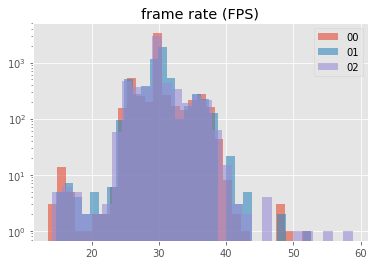

In [6]:
missed = {}
frames = {}
missed_threshold = 20
for camera in ["00", "01", "02"]:
    times = sorted([int(n.split("-")[1]) for n in file_list if n.split("-")[0] == camera])
    frames[camera] = len(times)
    fps = [1000.0 / (times[i + 1] - times[i]) for i in range(len(times) - 1)]
    missed[camera] = [(i, fps[i]) for i in range(len(fps)) if fps[i] < missed_threshold]
    plt.hist(fps, bins=30, log=True, alpha=0.6, label=camera)
plt.title("frame rate (FPS)")
plt.legend()
len(missed["02"]), "out of", frames["02"]

In [7]:
missed["02"]

[(49, 17.24137931034483),
 (1090, 15.151515151515152),
 (2469, 18.867924528301888),
 (2528, 15.384615384615385),
 (2543, 15.625),
 (2579, 15.873015873015873),
 (3059, 16.666666666666668),
 (3233, 15.625),
 (3310, 15.384615384615385),
 (3314, 17.24137931034483),
 (3697, 14.084507042253522),
 (3707, 17.24137931034483),
 (4131, 15.873015873015873),
 (4796, 15.873015873015873),
 (4846, 17.857142857142858),
 (5336, 17.24137931034483),
 (5339, 14.492753623188406),
 (5616, 19.23076923076923)]

In [8]:
tstamp = lambda x: int(x.split("-")[1])

In [9]:
camera = "00"
img_path = [rt_path + n + ".bmp.lz4" for n in file_list if n[:2] == camera]
img_path.sort(key=tstamp)

last_tstamp = tstamp(img_path[0]) - 34
t_int = []

black_scrn = np.zeros((1080, 1920, 3)).astype(np.uint8)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter(rt_path[:-1] + "_{:}.mp4".format(camera), fourcc, 30.0, (1920, 1080))

for file in img_path:
    img = imread_from_lz4(file)
    ts = tstamp(file)
    t_int.append(ts - last_tstamp)
    last_tstamp = ts
    
    if len(t_int) > 100:
        del t_int[0]

    cv2.putText(img, "{:06d}ms".format(ts), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),3,cv2.LINE_AA)
    cv2.putText(img, "{:.3f}FPS".format(1000.0 / np.mean(t_int)), (50, 170), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3, cv2.LINE_AA)
    
    #img = cv2.resize(img, (640, 360))
    
    black_f = int(np.round(t_int[-1] / 100.0 * 3 - 1))
    for i in range(black_f):
        writer.write(black_scrn)
        print("a black screen")
        
    writer.write(img)
    
writer.release()

a black screen
a black screen
a black screen
a black screen
a black screen
a black screen
a black screen
a black screen
a black screen
a black screen
a black screen
a black screen
a black screen
a black screen
a black screen
a black screen
a black screen
a black screen
a black screen
a black screen
a black screen
a black screen
a black screen
a black screen
